<a href="https://colab.research.google.com/github/FreddyR424/Deep_Learning/blob/master/Alffredi_Ramos_Milestone%2B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Milestone 2**

We have built two Convolutional Neural Network architectures in Milestone 1. Here, we will further try to achieve better performance by increasing the number of parameters/weights. Therefore, we will start this Milestone with three popular Transfer Learning architectures, namely, VGG16, ResNet v2, and Efficient Net. Please feel free to explore other pre-trained models as well. Link to Keras documentation for pre-trained models - https://keras.io/api/applications/

**Note:** We will mount our drive and import our dataset once again for Milestone 2.

## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is not a library that can be downloaded locally on your device.**

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [3]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### **Let us load the data**

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [4]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. Unlike in Milestone 1, we will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [6]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                        brightness_range=(0.,2.),
                                        rescale=1./255,
                                        shear_range=0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                                 target_size = (img_size, img_size),
                                                 color_mode = 'rgb',
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                  brightness_range=(0.,2.),
                                  rescale=1./255,
                                  shear_range=0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                            target_size = (img_size, img_size),
                                            color_mode = 'rgb',
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**

* In this model, we will import till the **'block5_pool'** layer of the VGG16 model. You can scroll down in the model summary and look for 'block5_pool'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'block5_pool' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [8]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable = False

# Add classification layers on top of it 
# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model

### **Compiling and Training the VGG16 Model**

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [10]:
# Write your code to compile the vggmodel. Use categorical crossentropy as the loss function, Adam Optimizer with 0.001 learning rate, and set metrics to 'accuracy'. 
vggmodel.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [11]:
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train the model for 20 epochs.
history = vggmodel.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 [==============================] - 482s 1s/step - loss: 1.3240 - accuracy: 0.3861 - val_loss: 1.3024 - val_accuracy: 0.3414
Epoch 2/20
473/473 [==============================] - 452s 955ms/step - loss: 1.2160 - accuracy: 0.4456 - val_loss: 1.2489 - val_accuracy: 0.4159
Epoch 3/20
473/473 [==============================] - 465s 984ms/step - loss: 1.1873 - accuracy: 0.4668 - val_loss: 1.3147 - val_accuracy: 0.3924
Epoch 4/20
473/473 [==============================] - 525s 1s/step - loss: 1.1657 - accuracy: 0.4749 - val_loss: 1.3094 - val_accuracy: 0.3637
Epoch 5/20
473/473 [==============================] - 517s 1s/step - loss: 1.1559 - accuracy: 0.4839 - val_loss: 1.2618 - val_accuracy: 0.3920
Epoch 6/20
473/473 [==============================] - 492s 1s/step - loss: 1.1539 - accuracy: 0.4863 - val_loss: 1.2710 - val_accuracy: 0.3677
Epoch 7/20
473/473 [==============================] - 519s 1s/step - loss: 1.1431 - accuracy: 0.4896 - val_loss: 1.2445 - val_accuracy: 

### **Evaluating the VGG16 model**

In [12]:
# Write your code to evaluate model performance on the test set
test_images, test_labels = next(test_set)
accuracy = vggmodel.evaluate(test_images, test_labels, verbose = 2)

1/1 - 1s - loss: 1.2570 - accuracy: 0.4375 - 744ms/epoch - 744ms/step


**Think About It:**

- What do you infer from the general trend in the training performance? 
- Is the training accuracy consistently improving? 
- Is the validation accuracy also improving similarly?

**Observations and Insights:**
- Overall trend in performance was postive.
- However, this increase in accuracy is not great. 
- The model does seem to be consistently improving but at a very slow pace. Once accuracy reached about 50%, the model slowed and only improved by ~1%. 
- The validation accuracy did not follow the train accuracy's trend of improvement. Instead, it seems the validation accuracy maintained accuracy of 34%-42% not improving after each epoch while giving a different scattered % after each epoch. 
- Upon evaluation of the model, we can see that the test set only had an accuracy of 44% with a loss of 1.383.

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [12]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                       

### **Model Building**

* In this model, we will import till the **'conv5_block3_add'** layer of the ResNet model. You can scroll down in the model summary and look for 'conv5_block3_add'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'conv5_block3_add' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [13]:
transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')
Resnet.trainable=False

# Add classification layers on top of it

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer_Resnet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(Resnet.input, pred) # Initializing the model

### **Compiling and Training the Model**

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          ) 


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)


callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 10

In [15]:
# Write your code to compile your resnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'. 
resnetmodel.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [16]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.
history = resnetmodel.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 [==============================] - 379s 784ms/step - loss: 1.4726 - accuracy: 0.2562 - val_loss: 1.3519 - val_accuracy: 0.3667
Epoch 2/20
473/473 [==============================] - 389s 822ms/step - loss: 1.4057 - accuracy: 0.2601 - val_loss: 1.3950 - val_accuracy: 0.2289
Epoch 3/20
473/473 [==============================] - 386s 817ms/step - loss: 1.3990 - accuracy: 0.2581 - val_loss: 1.4078 - val_accuracy: 0.2443
Epoch 4/20
473/473 [==============================] - 374s 790ms/step - loss: 1.3954 - accuracy: 0.2620 - val_loss: 1.3603 - val_accuracy: 0.3667
Epoch 5/20
473/473 [==============================] - 370s 783ms/step - loss: 1.3942 - accuracy: 0.2624 - val_loss: 1.3622 - val_accuracy: 0.3667
Epoch 6/20
473/473 [==============================] - 371s 786ms/step - loss: 1.3932 - accuracy: 0.2649 - val_loss: 1.3871 - val_accuracy: 0.2289
Epoch 7/20
473/473 [==============================] - 372s 787ms/step - loss: 1.3914 - accuracy: 0.2638 - val_loss: 1.3949 -

### **Evaluating the ResNet Model**

In [17]:
test_images, test_labels = next(test_set)
accuracy = resnetmodel.evaluate(test_images, test_labels, verbose = 2)

1/1 - 1s - loss: 1.3814 - accuracy: 0.3125 - 551ms/epoch - 551ms/step


**Observations and Insights:**
- The ResNet model did not perform well.
- The overall trend in the training of this model was stagnant.
- Accuracy never rose above 27%. 
- The validation accuracy also didnt seem to follow any trend, not increasing or decreasing.
- The validation accuracy was 36.7% and 23%, never increasing.
- Upon evaluation of the model, we can see that we had an accuracy of about 31%.

**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

In [18]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

35839040/35839040 [==============================] - 0s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model Building**

**Build your own Architecture on top of the transfer layer. Be sure to have a Flatten layer after your transfer layer and also make sure you have 4 neurons and softmax activation function in your last dense layer**

In [19]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
EfficientNet.trainable = False

# Add your Flatten layer.
x = Flatten()(transfer_layer_EfficientNet.output)

# Add your Dense layers and/or BatchNormalization and Dropout layers
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

# Add your final Dense layer with 4 neurons and softmax activation function.
pred = Dense(4, activation = 'softmax')(x)

Efficientnetmodel = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          ) 

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 10

In [21]:
# Write your code to compile your Efficientnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'.
Efficientnetmodel.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [22]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.
history = Efficientnetmodel.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 [==============================] - 120s 235ms/step - loss: 1.4720 - accuracy: 0.2549 - val_loss: 1.3680 - val_accuracy: 0.3667
Epoch 2/20
473/473 [==============================] - 110s 232ms/step - loss: 1.4050 - accuracy: 0.2648 - val_loss: 1.4295 - val_accuracy: 0.1601
Epoch 3/20
473/473 [==============================] - 108s 228ms/step - loss: 1.4018 - accuracy: 0.2517 - val_loss: 1.3754 - val_accuracy: 0.2289
Epoch 4/20
473/473 [==============================] - 112s 236ms/step - loss: 1.3967 - accuracy: 0.2636 - val_loss: 1.4066 - val_accuracy: 0.2289
Epoch 5/20
473/473 [==============================] - 110s 233ms/step - loss: 1.3926 - accuracy: 0.2621 - val_loss: 1.3886 - val_accuracy: 0.1601
Epoch 6/20
473/473 [==============================] - 110s 233ms/step - loss: 1.3910 - accuracy: 0.2596 - val_loss: 1.3644 - val_accuracy: 0.2443
Epoch 7/20
473/473 [==============================] - 110s 232ms/step - loss: 1.3908 - accuracy: 0.2679 - val_loss: 1.3691 -

### **Evaluating the EfficientnetNet Model**

In [23]:
# Write your code to evaluate the model performance on the test set
test_images, test_labels = next(test_set)
accuracy = Efficientnetmodel.evaluate(test_images, test_labels, verbose = 2)

4/4 [==============================] - 1s 171ms/step - loss: 1.3891 - accuracy: 0.2500


[1.3891026973724365, 0.25]

**Observations and Insights:**
- Like the ResNet model, the EfficientNet model performed poorly. 
- Training accuracy never surpassed 27%.
- The training accuracy also did not seem to follow any trend while training; remaining stagnant at about 25-26%.
- The validation accuracy also did not seem to follow any trend as well. We can see that the validation accuracies would alternate between 16%, 23%, 24%, or 37% in no particular order.
- Upon evaluation of the EfficientNet model, we had an accuracy of 25%. 

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [24]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                        brightness_range=(0.,2.),
                                        rescale=1./255,
                                        shear_range=0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                                 target_size = (img_size, img_size),
                                                 color_mode = 'grayscale',
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                  brightness_range=(0.,2.),
                                  rescale=1./255,
                                  shear_range=0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                            target_size = (img_size, img_size),
                                            color_mode = 'grayscale',
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

* In this network, we plan to have 5 Convolutional Blocks
* Add first Conv2D layer with **64 filters** and a **kernel size of 2**. Use the 'same' padding and provide the **input shape = (48, 48, 1)**. Use **'relu' activation**.
* Add your BatchNormalization layer followed by a LeakyRelU layer with Leaky ReLU parameter of **0.1**
* Add MaxPooling2D layer with **pool size = 2**.
* Add a Dropout layer with a Dropout Ratio of **0.2**. This completes the first Convolutional block.
* Add a second Conv2D layer with **128 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.**
* Follow this up with a similar BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer like above to complete your second Convolutional Block.
* Add a third Conv2D layer with **512 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.** Once again, follow it up with a BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer to complete your third Convolutional block.
* Add a fourth block, with the Conv2D layer having **512 filters**.
* Add the fifth block, having **128 filters**.
* Then add your Flatten layer, followed by your Dense layers.
* Add your first Dense layer with **256 neurons** followed by a BatchNormalization layer, a **'relu'** Activation, and a Dropout layer. This forms your first Fully Connected block
* Add your second Dense layer with **512 neurons**, again followed by a BatchNormalization layer, **relu** activation, and a Dropout layer.
* Add your final Dense layer with 4 neurons.
* Compile your model with the optimizer of your choice.

In [29]:
no_of_classes = 4

model3 = Sequential()

# Add 1st CNN Block
model3.add(Conv2D(64, (2, 2), input_shape = (48, 48, 1), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

# Add 2nd CNN Block
model3.add(Conv2D(128, (2, 2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

# Add 3rd CNN Block
model3.add(Conv2D(512, (2, 2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

# Add 4th CNN Block
model3.add(Conv2D(512, (2, 2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

# Add 5th CNN Block
model3.add(Conv2D(128, (2, 2), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

model3.add(Flatten())

# First fully connected layer
model3.add(Dense(256, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

# Second fully connected layer
model3.add(Dense(128, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Dense(4, activation = 'softmax'))

model3.add(Dense(no_of_classes, activation = 'softmax'))

### **Compiling and Training the Model**

In [30]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

epochs = 35

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]

In [31]:
# Write your code to compile your model3. Use categorical crossentropy as the loss function, Adam Optimizer with 0.003 learning rate, and set metrics to 'accuracy'.
model3.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [33]:
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train your model for 35 epochs.
history = model3.fit(train_set, validation_data = validation_set, epochs = 35)

Epoch 1/35
473/473 [==============================] - 391s 823ms/step - loss: 1.3882 - accuracy: 0.2722 - val_loss: 1.3950 - val_accuracy: 0.2680
Epoch 2/35
473/473 [==============================] - 381s 806ms/step - loss: 1.3715 - accuracy: 0.2896 - val_loss: 1.3575 - val_accuracy: 0.2678
Epoch 3/35
473/473 [==============================] - 384s 812ms/step - loss: 1.3521 - accuracy: 0.3079 - val_loss: 1.3196 - val_accuracy: 0.2917
Epoch 4/35
473/473 [==============================] - 384s 813ms/step - loss: 1.3132 - accuracy: 0.3411 - val_loss: 1.2835 - val_accuracy: 0.3108
Epoch 5/35
473/473 [==============================] - 385s 813ms/step - loss: 1.2707 - accuracy: 0.3595 - val_loss: 1.2569 - val_accuracy: 0.3376
Epoch 6/35
473/473 [==============================] - 384s 812ms/step - loss: 1.2400 - accuracy: 0.3761 - val_loss: 1.2459 - val_accuracy: 0.3126
Epoch 7/35
473/473 [==============================] - 384s 811ms/step - loss: 1.2147 - accuracy: 0.3806 - val_loss: 1.2112 -

### **Evaluating the Model on Test Set**

In [34]:
# Write your code to evaluate the model performance on the test set
test_images, test_labels = next(test_set)
accuracy = model3.evaluate(test_images, test_labels, verbose = 2)

1/1 - 0s - loss: 0.9819 - accuracy: 0.5000 - 201ms/epoch - 201ms/step


**Observations and Insights:**
- Model 3 performed the best out of the 4 models trained and compiled in this milestone.
- The training accuracy followed a positive trend increasing after each epoch.
- The validation accuracy also followed a positive trend up until the final epochs where the validation accuracy would shift from 52%-55%.
- Upon evaluating the model on the test set, we had an accuracy of 50%, having out performed the Vgg16, ResNet, and EfficientNet models. 

### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 1s 168ms/step
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        32
           1       0.56      0.47      0.51        32
           2       0.52      0.69      0.59        32
           3       0.93      0.88      0.90        32

    accuracy                           0.68       128
   macro avg       0.69      0.68      0.68       128
weighted avg       0.69      0.68      0.68       128



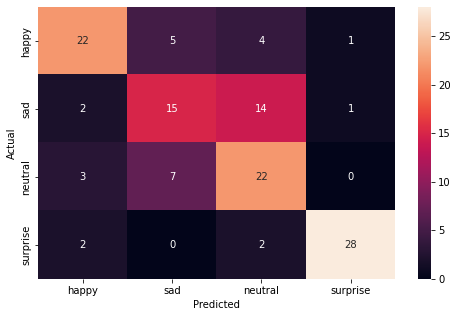

In [35]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
test_images, test_labels = next(test_set)

# Write the name of your chosen model in the blank
pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**
- The highest F1 scores belong to the 'happy' and 'surprise' classes.
- The highest precision also belongs to the 'happy' and 'surprise' classes. 
- The model overall performed decently at around ~70% accuracy; better than the Vgg16, ResNet, and EfficientNet models. 
- The recall has an average of 0.68 indicating that the model is good at identifying some facial expressions and poor at identifying other facial expressions.
- The misclassification is mostly with the the facial expressions 'sad' and 'neutral'.

## **Conclusion:**
- Finding the most efficient architecture that can classify the images of facial emotions into their respective classes.
- These 4 models compiled and trained in this milestone were not that efficient or accurate. Computation times for these models were over 2 hours each, making them nonefficient as well as not accurate.
- We visualized 4 types of facial emotions: 'happy', 'sad', 'neutral', and 'surprise'. It is relatively easy to detect someones facial emotions from happy and sad, but distinguishing between sad and neutral can be difficult. As shown in the heatmap above, the models had trouble as well detecting/distinguishing the two.
- The Vgg16 model did not perform well. 
- The poorest performing models were both the ResNet and EfficientNet models with accuracies of 31% and 25% respectively. They also had the highest computation times (about 2-3 hours each).
- The best performing model of the 4 in this milestone was model3 with a test accuracy of 50%.

### **Insights**

### **Refined insights**:

- Vgg16, ResNet, and EfficientNet models are not ideal for the detection/recognition of facial emotions.
- model3 performed the best out of the 4 models in this milestone, however, it still did not perform to our liking. 
- Overall, all 4 models did not perform to my liking.

### **Comparison of various techniques and their relative performance**:

- The block5_pool layer of the Vgg16 model was imported, compiled, and trained. We got a training accuracy of 54%, a validation accuracy of 42%, and a test set accuracy of 44%. Overall, the Vgg16 model did not perform well.
- The conv5_block3_add layer of the ResNet model was imported, compiled, and trained. We got a training accuracy of 27%, a validation accuracy of 37%, and a test set accuracy of 31%. This model perfomed slightly worse than the Vgg16 model.
- The block6e_expand_activation layer of the EfficientNet model was imported, compiled, and trained. We got a training accuracy of 26%, a validation accuracy of 37%, and a test set accuracy of 25%. This model perfomed the worst out of all 4 models used in this milestone.
- model3 was compiled and trained. We got a training accuracy of 70%, a validation accuracy of 55% and a test set accuracy of 50%. Eventhough the model did not perform optimally and effieicntly as we would like, it still outperformed the other 3 models by a landslide. 
- Possible scopes of improvement could be using different layers in the Vgg16, Resnet, and EfficientNet models, tuning the parameters, and chaning the weights. 

### **Proposal for the final solution design**:

- I believe that adopting the second CNN compiled and trained in milestone 1 would be best adopted for this project overall. I think it would be the best solution because the model outperformed every other model that was compiled and trained in this project. model2 (from milestone 1) had an overall great accuracy compared to the other models. model2 had a training accuracy of 80%, a validation accuracy of 70%, and a test set accuracy of 84%. Not to mention the less computation time needed compared to all other models used throughout this project. 